In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from numpy import arange, sin, pi, random

np.random.seed(1234)

# Global hyper-parameters
sequence_length = 100
# each sample randomly duplicated between 0 and 9 times, see dropin function
random_data_dup = 10
epochs = 1
batch_size = 50

Using TensorFlow backend.


In [1]:
!pip list

Package             Version    
------------------- -----------
absl-py             0.6.1      
astor               0.7.1      
astroid             2.1.0      
autopep8            1.4.3      
backcall            0.1.0      
bleach              3.1.0      
cycler              0.10.0     
decorator           4.3.2      
defusedxml          0.5.0      
entrypoints         0.3        
gast                0.2.1.post1
grpcio              1.17.1     
h5py                2.9.0      
ipykernel           5.1.0      
ipython             7.2.0      
ipython-genutils    0.2.0      
ipywidgets          7.4.2      
isort               4.3.4      
jedi                0.13.2     
Jinja2              2.10       
jsonschema          2.6.0      
jupyter             1.0.0      
jupyter-client      5.2.4      
jupyter-console     6.0.0      
jupyter-core        4.4.0      
kafka-python        1.4.4      
Keras               2.2.4      
Keras-Applications  1.0.6      
Keras-Preprocessing 1.0.5      
kiwisolv

In [3]:
def dropin(X, y):
    """ The name suggests the inverse of dropout, i.e. adding more samples.
     See Data Augmentation section at
    http://simaaron.github.io/Estimating-rainfall-from-weather-radar-readings-using-recurrent-neural-networks/
    :param X: Each row is a training sequence
    :param y: Tne target we train and will later predict
    :return: new augmented X, y
    """
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    X_hat = []
    y_hat = []
    for i in range(0, len(X)):
        for j in range(0, np.random.random_integers(0, random_data_dup)):
            X_hat.append(X[i, :])
            y_hat.append(y[i])
    return np.asarray(X_hat), np.asarray(y_hat)

In [4]:
def gen_wave():
    """ Generate a synthetic wave by adding up a few sine waves and some noise
    :return: the final wave
    """
    t = np.arange(0.0, 10.0, 0.01)
    wave1 = sin(2 * 2 * pi * t)
    noise = random.normal(0, 0.1, len(t))
    wave1 = wave1 + noise
    print("wave1", len(wave1))
    wave2 = sin(2 * pi * t)
    print("wave2", len(wave2))
    t_rider = arange(0.0, 0.5, 0.01)
    wave3 = sin(10 * pi * t_rider)
    print("wave3", len(wave3))
    insert = round(0.8 * len(t))
    wave1[insert:insert + 50] = wave1[insert:insert + 50] + wave3
    return wave1 + wave2

In [5]:
def z_norm(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

In [6]:
def get_split_prep_data(train_start, train_end,
                        test_start, test_end):
    data = gen_wave()
    print("Length of Data", len(data))

    # train data
    print("Creating train data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print("Mean of train data : ", result_mean)
    print("Train data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)  # shuffles in-place
    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_train, y_train = dropin(X_train, y_train)

    # test data
    print("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print("Mean of test data : ", result_mean)
    print("Test data shape  : ", result.shape)

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test

In [7]:
def build_model():
    model = Sequential()
    layers = {'input': 1, 'hidden1': 64,
              'hidden2': 256, 'hidden3': 100, 'output': 1}

    model.add(LSTM(
        input_length=sequence_length - 1,
        input_dim=layers['input'],
        output_dim=layers['hidden1'],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers['hidden2'],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers['hidden3'],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers['output']))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("Compilation Time : ", time.time() - start)
    return model

In [8]:
def run_network(model=None, data=None):
    global_start_time = time.time()

    if data is None:
        print('Loading data... ')
        # train on first 700 samples and test on next 300 samples (has anomaly)
        X_train, y_train, X_test, y_test = get_split_prep_data(
            0, 700, 500, 1000)
    else:
        X_train, y_train, X_test, y_test = data

    print('\nData Loaded. Compiling...\n')

    if model is None:
        model = build_model()

    try:
        print("Training...")
        model.fit(
            X_train, y_train,
            batch_size=batch_size, nb_epoch=epochs, validation_split=0.05)
        print("Predicting...")
        predicted = model.predict(X_test)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print('Training duration (s) : ', time.time() - global_start_time)
        return model, y_test, 0

    try:
        plt.figure(1)
        plt.subplot(311)
        plt.title("Actual Test Signal w/Anomalies")
        plt.plot(y_test[:len(y_test)], 'b')
        plt.subplot(312)
        plt.title("Predicted Signal")
        plt.plot(predicted[:len(y_test)], 'g')
        plt.subplot(313)
        plt.title("Squared Error")
        mse = ((y_test - predicted) ** 2)
        plt.plot(mse, 'r')
        plt.show()
    except Exception as e:
        print("plotting exception")
        print(str(e))

    print('Training duration (s) : ', time.time() - global_start_time)

    return model, y_test, predicted

Loading data... 
wave1 1000
wave2 1000
wave3 50
Length of Data 1000
Creating train data...
Mean of train data :  0.0017174984265156401
Train data shape  :  (600, 100)
X shape: (600, 99)
y shape: (600,)
Creating test data...
Mean of test data :  0.01647475124693149
Test data shape  :  (400, 100)
Shape X_train (2958, 99)
Shape X_test (400, 99)

Data Loaded. Compiling...



/home/flaviorissosakakibara/Documents/IGTI/codigo/logparser/venv36/lib64/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead
  
/home/flaviorissosakakibara/Documents/IGTI/codigo/logparser/venv36/lib64/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
/home/flaviorissosakakibara/Documents/IGTI/codigo/logparser/venv36/lib64/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(99, 1), units=64)`
  # Remove the CWD from sys.path while we load stuff.
/home/flaviorissosakakibara/Documents/IGTI/codigo/logparser/venv36/lib64/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units

Compilation Time :  0.019568920135498047
Training...
Train on 2810 samples, validate on 148 samples
Epoch 1/1
2810/2810 [==============================] - 19s 7ms/step - loss: 0.1648 - val_loss: 0.6042
Predicting...
Reshaping predicted


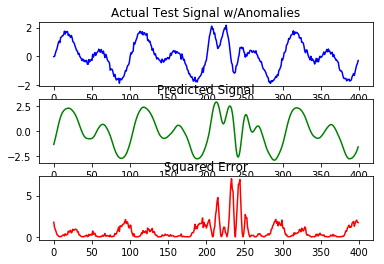

Training duration (s) :  23.897878408432007


In [9]:
if __name__ == '__main__':
    run_network()